# **Loading data and packages**

**Libraries import**

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ipywidgets import interact
import ipywidgets as widgets
from joblib import load, dump

from sklearn.model_selection import (
    train_test_split, LeaveOneOut, cross_validate, learning_curve, cross_val_predict
)
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    make_scorer, confusion_matrix, classification_report, roc_curve, auc
)
from sklearn.ensemble import (
    ExtraTreesClassifier, RandomForestClassifier,
    AdaBoostClassifier, GradientBoostingClassifier
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest, f_classif

from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.metrics import geometric_mean_score

import os
import pandas as pd
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import RandomOverSampler, ADASYN
from imblearn.under_sampling import RandomUnderSampler, TomekLinks

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ipywidgets as widgets
from IPython.display import display
from imblearn.over_sampling import SMOTENC

import os
import numpy as np
import pandas as pd
from sklearn.model_selection import LeaveOneOut, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from imblearn.metrics import geometric_mean_score
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTENC
from imblearn.under_sampling import RandomUnderSampler, TomekLinks



# Data selection
clinic_dataset = '../datasets/df_clinic_ENTPD1.csv'
hemogram_dataset = '../datasets/df_hemogram_ENTPD1.csv'
clinic_dataset_cat1 = '../datasets/cat1_df_clinic_ENTPD1.csv'
hemogram_dataset_cat1 = '../datasets/df_hemogram_cat_1.csv'
clinic_dataset_cat2 = '../datasets/cat2_df_clinic_ENTPD1.csv'
hemogram_dataset_cat2 = '../datasets/cat2_df_hemogram_ENTDP1.csv'

**Data import**

In [2]:
# Definindo variáveis globais para armazenar o DataFrame e o nome do dataset
df = pd.DataFrame()
dataset_name = None
X = None
y = None
balancing_method_selected = None  # Variável global para armazenar o método de balanceamento selecionado

# Função para listar arquivos CSV no diretório
def list_csv_files(directory):
    return [f for f in os.listdir(directory) if f.endswith('.csv')]

# Função para carregar e processar o dataset selecionado
def load_and_process_data(selected_file):
    global df, dataset_name, X, y
    dataset_name = selected_file
    file_path = os.path.join('..', 'datasets', 'feature_selection', dataset_name)

    if not os.path.exists(file_path):
        print(f"Erro: O arquivo '{file_path}' não foi encontrado.")
        return None

    df = pd.read_csv(file_path)

    # Convertendo 'Gênero' para valores numéricos
    if 'Gênero' in df.columns:
        df['Gênero'] = df['Gênero'].replace({'M': 0, 'F': 1})

    # Normalizando 'Idade_clinica'
    if 'Idade_clinica' in df.columns:
        scaler = MinMaxScaler()
        df['Idade_clinica'] = scaler.fit_transform(df[['Idade_clinica']])

    # Definindo X (features) e y (target)
    X = df.drop(columns=['PROVAVEL_HAM/TSP']) 
    y = df['PROVAVEL_HAM/TSP'] 

    print(f"Data Loaded and Processed Successfully! Dataset: {dataset_name}")
    return df.head()

# Função para definir o método de balanceamento selecionado
def set_balancing_method(method):
    global balancing_method_selected  # Declarando a variável como global
    balancing_method_selected = method  # Atribui o método selecionado à variável
    print(f"Método de balanceamento selecionado: {balancing_method_selected}")

# Função para aplicar o método de balanceamento selecionado
def apply_balancing(X, y):
    global balancing_method_selected
    if balancing_method_selected is None:
        print("Nenhum método de balanceamento foi selecionado.")
        return X, y

    if balancing_method_selected == 'Random Over Sampler':
        balancer = RandomOverSampler(random_state=42)
    elif balancing_method_selected == 'SMOTENC':
        # Ajusta dinamicamente as colunas categóricas para o SMOTENC
        categorical_columns = [col for col in X.columns if col != 'Idade_clinica']
        categorical_features = [X.columns.get_loc(col) for col in categorical_columns]
        balancer = SMOTENC(categorical_features=categorical_features, random_state=42)
    elif balancing_method_selected == 'Random Under Sampler':
        balancer = RandomUnderSampler(random_state=42)
    elif balancing_method_selected == 'Tomek Links':
        balancer = TomekLinks()
    else:
        print(f"Método de balanceamento desconhecido: {balancing_method_selected}")
        return X, y

    # Aplicando o método de balanceamento
    X_res, y_res = balancer.fit_resample(X, y)
    #print(f"Balanceamento aplicado com sucesso usando: {balancing_method_selected}")
    return X_res, y_res

# Definir o diretório onde os arquivos CSV estão localizados
directory = '../datasets/feature_selection/'

# Listar os arquivos CSV disponíveis no diretório
csv_files = list_csv_files(directory)

# Criar um widget de seleção com os arquivos listados
file_selector = widgets.Dropdown(
    options=csv_files,
    description='Select File:'
)

# Criar um widget para selecionar o método de balanceamento
balancing_methods = ['Random Over Sampler', 'SMOTENC', 'Random Under Sampler', 'Tomek Links']
method_selector = widgets.Dropdown(
    options=balancing_methods,
    description='Balancing Method:'
)

# Função interativa para carregar e processar o arquivo CSV selecionado
@interact(selected_file=file_selector)
def load_and_process_selected_file(selected_file):
    return load_and_process_data(selected_file)

# Função interativa para aplicar o método de balanceamento selecionado
@interact(selected_method=method_selector)
def apply_selected_balancing_method(selected_method):
    set_balancing_method(selected_method)
    X_res, y_res = apply_balancing(X, y)  # Aplica o balanceamento aos dados carregados
    print(f"Shape dos dados balanceados: {X_res.shape}, {y_res.shape}")

interactive(children=(Dropdown(description='Select File:', options=('df_Hemogram_data_cat_1_RUS_K6.csv', 'df_H…

interactive(children=(Dropdown(description='Balancing Method:', options=('Random Over Sampler', 'SMOTENC', 'Ra…

#  **Definition of variables, models and metrics**

**Define the variables (X and y) and classifiers** 

In [3]:
# List of model names that have been adjusted
model_names = ['DT', 'GB', 'LR', 'MLP', 'NB', 'RF', 'SVM', 'KNN', 'AB', 'LSVM']

# Directory where models and results are saved
model_dir = '../models/'

# Dictionary to store loaded templates
classifiers = {}

# Function for loading templates
def load_model(model_name):
    model_path = os.path.join(model_dir, f'best_{model_name}_model.joblib')

    if os.path.exists(model_path):
        # Load the model
        model = load(model_path)

        
        if isinstance(model, SVC):
            model.probability = True

        # Add the model to the classifiers dictionary using the corresponding name
        classifiers[model_name] = model

        print(f'Modelo {model_name} carregado com sucesso.')
    else:
        print(f'Arquivo para o modelo {model_name} não encontrado.')

# Iterate over all the model names and load them
for model_name in model_names:
    load_model(model_name)

Modelo DT carregado com sucesso.
Modelo GB carregado com sucesso.
Modelo LR carregado com sucesso.
Modelo MLP carregado com sucesso.
Modelo NB carregado com sucesso.
Modelo RF carregado com sucesso.
Modelo SVM carregado com sucesso.
Modelo KNN carregado com sucesso.
Modelo AB carregado com sucesso.
Modelo LSVM carregado com sucesso.


In [11]:
print(balancing_method_selected)

SMOTENC


# **Model evaluation**

Generation of the results

In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import LeaveOneOut, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from imblearn.metrics import geometric_mean_score
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTENC
from imblearn.under_sampling import RandomUnderSampler, TomekLinks

# Lista para armazenar os resultados
results = []

# Definir a estratégia Leave-One-Out
loo = LeaveOneOut()

# Função para aplicar o método de balanceamento selecionado
def get_balancing_method():
    global balancing_method_selected
    if balancing_method_selected == 'Random Over Sampler':
        return RandomOverSampler(random_state=42)
    elif balancing_method_selected == 'SMOTENC':
        categorical_columns = [col for col in X.columns if col != 'Idade_clinica']
        categorical_features = [X.columns.get_loc(col) for col in categorical_columns]
        return SMOTENC(categorical_features=categorical_features, random_state=42)
    elif balancing_method_selected == 'Random Under Sampler':
        return RandomUnderSampler(random_state=42)
    elif balancing_method_selected == 'Tomek Links':
        return TomekLinks()
    else:
        print("Nenhum método de balanceamento válido selecionado.")
        return None

# Iterando sobre os classificadores
for clf_name, clf in classifiers.items():
    balancing_method = get_balancing_method()
    if balancing_method is None:
        print(f"Erro: Nenhum método de balanceamento válido para o classificador {clf_name}. Pulando este classificador.")
        continue

    # Definir o pipeline
    pipeline = Pipeline([
        ('balancing', balancing_method),
        ('classifier', clf)
    ])

    # Armazenar métricas por iteração
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    roc_auc_scores = []
    gmean_scores = []

    # Executar Leave-One-Out manualmente
    for train_index, test_index in loo.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Treinar e prever
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        try:
            y_prob = pipeline.predict_proba(X_test)[:, 1]
        except AttributeError:
            if hasattr(clf, "decision_function"):
                y_prob = pipeline.decision_function(X_test)
                # Normalizar
                y_prob = (y_prob - y_prob.min()) / (y_prob.max() - y_prob.min())
            else:
                y_prob = np.zeros_like(y_pred)

        # Adicionar métricas da iteração
        accuracy_scores.append(accuracy_score(y_test, y_pred))
        precision_scores.append(precision_score(y_test, y_pred, zero_division=0))
        recall_scores.append(recall_score(y_test, y_pred, zero_division=0))
        f1_scores.append(f1_score(y_test, y_pred, zero_division=0))
        roc_auc_scores.append(roc_auc_score(y_test, y_prob) if len(np.unique(y_test)) > 1 else np.nan)
        gmean_scores.append(geometric_mean_score(y_test, y_pred))

    # Calcular métricas globais
    y_pred_global = cross_val_predict(pipeline, X, y, cv=loo)
    try:
        y_prob_global = cross_val_predict(pipeline, X, y, cv=loo, method='predict_proba')[:, 1]
    except AttributeError:
        if hasattr(clf, "decision_function"):
            y_prob_global = cross_val_predict(pipeline, X, y, cv=loo, method='decision_function')
            y_prob_global = (y_prob_global - y_prob_global.min()) / (y_prob_global.max() - y_prob_global.min())
        else:
            y_prob_global = np.zeros_like(y_pred_global)

    # Adicionar métricas ao DataFrame
    results.append({
        'classifier': clf_name,
        'Accuracy': accuracy_score(y, y_pred_global),
        'Accuracy Std': np.std(accuracy_scores),
        'Precision': precision_score(y, y_pred_global, zero_division=0),
        'Precision Std': np.std(precision_scores),
        'Recall': recall_score(y, y_pred_global, zero_division=0),
        'Recall Std': np.std(recall_scores),
        'F1': f1_score(y, y_pred_global, zero_division=0),
        'F1 Std': np.std(f1_scores),
        'G-Mean': geometric_mean_score(y, y_pred_global),
        'G-Mean Std': np.std(gmean_scores),    
        'ROC AUC': roc_auc_score(y, y_prob_global),
    })

# Converter resultados para DataFrame
results_df = pd.DataFrame(results)

# Exibir os resultados
print(results_df)


/home/bioinfo-icb/anaconda3/envs/ML_HTLV/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bioinfo-icb/anaconda3/envs/ML_HTLV/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bioinfo-icb/anaconda3/envs/ML_HTLV/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bioinfo-icb/anaconda3/envs/ML_H

  classifier  Accuracy  Accuracy Std  Precision  Precision Std    Recall  \
0         DT  0.752809      0.431379   0.529412       0.301492  0.391304   
1         GB  0.584270      0.492847   0.208333       0.230269  0.217391   
2         LR  0.539326      0.498451   0.250000       0.301492  0.391304   
3        MLP  0.584270      0.492847   0.281250       0.301492  0.391304   
4         NB  0.539326      0.498451   0.218750       0.269194  0.304348   
5         RF  0.573034      0.494637   0.200000       0.230269  0.217391   
6        SVM  0.741573      0.437770   0.500000       0.105403  0.043478   
7        KNN  0.606742      0.488473   0.333333       0.341543  0.521739   
8         AB  0.505618      0.499968   0.111111       0.180476  0.130435   
9       LSVM  0.573034      0.494637   0.297297       0.329120  0.478261   

   Recall Std        F1    F1 Std    G-Mean  G-Mean Std   ROC AUC  
0    0.301492  0.450000  0.301492  0.586407    0.431379  0.561924  
1    0.230269  0.212766  0.

/home/bioinfo-icb/anaconda3/envs/ML_HTLV/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/bioinfo-icb/anaconda3/envs/ML_HTLV/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/bioinfo-icb/anaconda3/envs/ML_HTLV/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/bioinfo-icb/anaconda3/envs/ML_HTLV/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [6]:
output_directory = '../results'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Caminho do arquivo
output_file = os.path.join(output_directory, 'results_metrics.csv')

# Salvar o DataFrame em formato CSV
results_df.to_csv(output_file, index=False)

# Exibir mensagem de confirmação
print(f"Resultados salvos em: {output_file}")


Resultados salvos em: ../results/results_metrics.csv


Heatmap plot

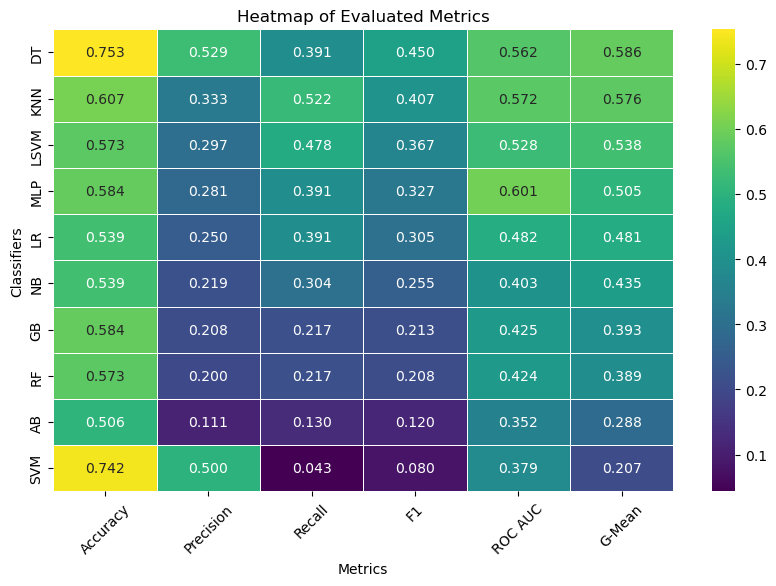

In [7]:
# Defining the names of the evaluation metrics
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC AUC', 'G-Mean']

# Selecting the metrics for the heatmap and configuring the index
heatmap_df = results_df[metric_names].set_index(results_df['classifier'])

# Sorting the DataFrame by G-Mean value
heatmap_df = heatmap_df.sort_values(by='G-Mean', ascending=False)

# Plotting the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_df, cmap='viridis', annot=True, fmt=".3f", linewidths=.5)
plt.title('Heatmap of Evaluated Metrics')
plt.xlabel('Metrics')
plt.ylabel('Classifiers')
plt.xticks(rotation=45)
plt.savefig('../results/heatmap.jpeg')
plt.show()


Polar plot

Dropdown(description='Modelo 1', options=('GB', 'LR', 'MLP', 'SVM', 'LSVM', 'DT', 'RF', 'NB', 'AB', 'KNN'), va…

Dropdown(description='Modelo 2', index=1, options=('GB', 'LR', 'MLP', 'SVM', 'LSVM', 'DT', 'RF', 'NB', 'AB', '…

Dropdown(description='Modelo 3', index=2, options=('GB', 'LR', 'MLP', 'SVM', 'LSVM', 'DT', 'RF', 'NB', 'AB', '…

Dropdown(description='Modelo 4', index=3, options=('GB', 'LR', 'MLP', 'SVM', 'LSVM', 'DT', 'RF', 'NB', 'AB', '…

Button(description='Gerar Gráfico', style=ButtonStyle())

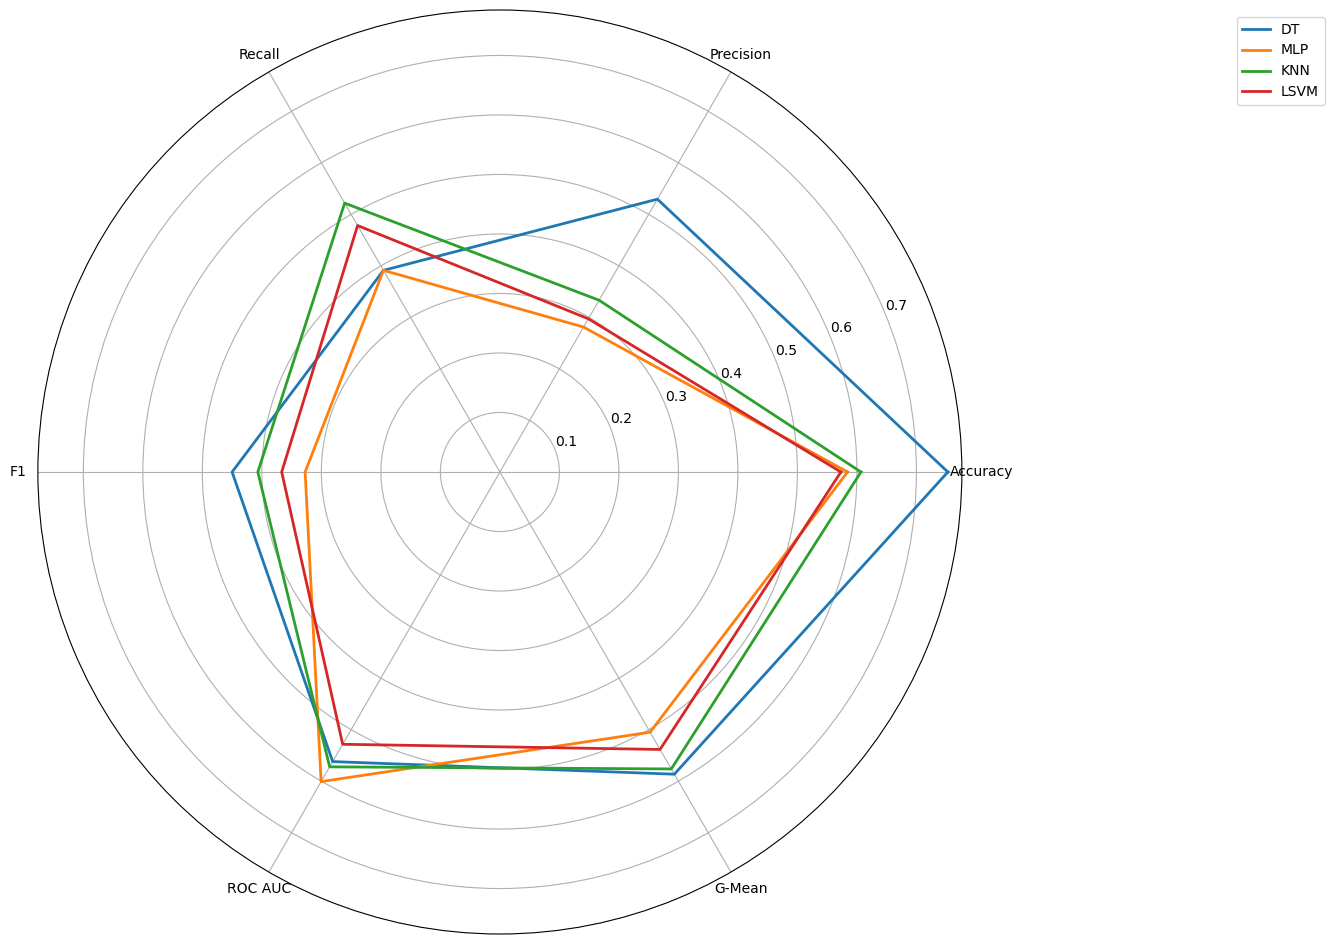

Gráfico salvo em: ../results/polar_plot.jpeg


In [8]:
# Define the available classifiers
available_models = ['GB', 'LR', 'MLP', 'SVM', 'LSVM', 'DT', 'RF', 'NB', 'AB', 'KNN']

# Model selection widgets
model_selector_1 = widgets.Dropdown(options=available_models, description='Modelo 1', value=available_models[0])
model_selector_2 = widgets.Dropdown(options=available_models, description='Modelo 2', value=available_models[1])
model_selector_3 = widgets.Dropdown(options=available_models, description='Modelo 3', value=available_models[2])
model_selector_4 = widgets.Dropdown(options=available_models, description='Modelo 4', value=available_models[3])

# Display the widgets to the user
display(model_selector_1, model_selector_2, model_selector_3, model_selector_4)
def plot_selected_models(results_df):
    # Get the selected models from the dropdowns
    selected_models = [model_selector_1.value, model_selector_2.value, model_selector_3.value, model_selector_4.value]

    # Check for duplicates in the selected templates
    if len(selected_models) != len(set(selected_models)):
        print("Por favor, selecione modelos diferentes em cada widget.")
        return

    # Filter the results for the selected models
    results_df_filtered = results_df[results_df['classifier'].isin(selected_models)]

    # Creating the figure for the polar graph
    fig, ax = plt.subplots(figsize=(12, 12), subplot_kw={'projection': 'polar'})

    # Iterate over each row of the filtered DataFrame and plot the metrics on the polar graph
    for i, row in results_df_filtered.iterrows():
        # Take the metrics in order
        metrics = [row['Accuracy'], row['Precision'], row['Recall'], row['F1'], row['ROC AUC'], row['G-Mean']]
        
        # Connect the first value to the last to close the graph
        metrics.append(metrics[0])
        
        # Define the angles and plot on the polar graph
        angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=True)
        ax.plot(angles, metrics, label=row['classifier'], linewidth=2)

    # Configuring the axis labels
    ax.set_xticks(np.linspace(0, 2*np.pi, 6, endpoint=False))
    ax.set_xticklabels(['Accuracy', 'Precision', 'Recall', 'F1', 'ROC AUC', 'G-Mean'])

    # Adicionar uma legenda fora do gráfico
    ax.legend(loc='upper right', bbox_to_anchor=(1.4, 1))

    # Define the colors of the graph
    ax.set_prop_cycle(color=plt.cm.viridis(np.linspace(0, 1, len(results_df_filtered))))

    # Display the graph
    plt.show()

    # Save the graph
    save_path = '../results/polar_plot.jpeg'
    fig.savefig(save_path, bbox_inches='tight')
    print(f"Gráfico salvo em: {save_path}")
    
# Create button to plot the graph
plot_button = widgets.Button(description="Gerar Gráfico")

# Function to be executed when the button is clicked
def on_plot_button_clicked(b):
    plot_selected_models(results_df)
plot_button.on_click(on_plot_button_clicked)
display(plot_button)


Bar graph comparation plot

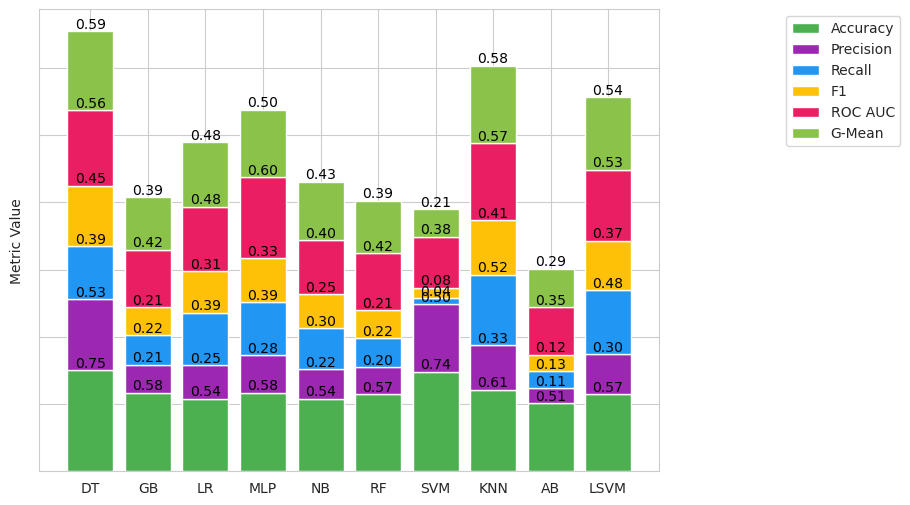

Gráfico salvo em: ../results/bar_plot_all_models.png


In [9]:
# Configure the seaborn style
sns.set_style("whitegrid")

# Create the figure
fig, ax = plt.subplots(figsize=(8, 6))

# Create the bars for each metric
bars = ax.bar(range(len(results_df)), results_df['Accuracy'], label='Accuracy', color='#4CAF50')  # Green
for i, (bar, value) in enumerate(zip(bars, results_df['Accuracy'])):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f"{value:.2f}", ha='center', va='bottom', color='black')

bars = ax.bar(range(len(results_df)), results_df['Precision'], bottom=results_df['Accuracy'], label='Precision', color='#9C27B0')  # Purple
for i, (bar, value) in enumerate(zip(bars, results_df['Precision'])):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + results_df['Accuracy'].iloc[i], f"{value:.2f}", ha='center', va='bottom', color='black')

bars = ax.bar(range(len(results_df)), results_df['Recall'], bottom=results_df['Accuracy'] + results_df['Precision'], label='Recall', color='#2196F3')  # Blue
for i, (bar, value) in enumerate(zip(bars, results_df['Recall'])):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + (results_df['Accuracy'] + results_df['Precision']).iloc[i], f"{value:.2f}", ha='center', va='bottom', color='black')

bars = ax.bar(range(len(results_df)), results_df['F1'], bottom=results_df['Accuracy'] + results_df['Precision'] + results_df['Recall'], label='F1', color='#FFC107')  # Yellow
for i, (bar, value) in enumerate(zip(bars, results_df['F1'])):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + (results_df['Accuracy'] + results_df['Precision'] + results_df['Recall']).iloc[i], f"{value:.2f}", ha='center', va='bottom', color='black')

bars = ax.bar(range(len(results_df)), results_df['ROC AUC'], bottom=results_df['Accuracy'] + results_df['Precision'] + results_df['Recall'] + results_df['F1'], label='ROC AUC', color='#E91E63')  # Pink
for i, (bar, value) in enumerate(zip(bars, results_df['ROC AUC'])):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + (results_df['Accuracy'] + results_df['Precision'] + results_df['Recall'] + results_df['F1']).iloc[i], f"{value:.2f}", ha='center', va='bottom', color='black')

bars = ax.bar(range(len(results_df)), results_df['G-Mean'], bottom=results_df['Accuracy'] + results_df['Precision'] + results_df['Recall'] + results_df['F1'] + results_df['ROC AUC'], label='G-Mean', color='#8BC34A')  # Light Green
for i, (bar, value) in enumerate(zip(bars, results_df['G-Mean'])):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + (results_df['Accuracy'] + results_df['Precision'] + results_df['Recall'] + results_df['F1'] + results_df['ROC AUC']).iloc[i], f"{value:.2f}", ha='center', va='bottom', color='black')

# Chart settings
ax.set_xticks(range(len(results_df)))
ax.set_yticklabels([])
ax.set_xticklabels(results_df['classifier'])
ax.set_ylabel('Metric Value')
ax.legend(loc='upper right', bbox_to_anchor=(1.4, 1))

# Display the graph
plt.show()

# Save the graphs
save_path = '../results/bar_plot_all_models.png'
fig.savefig(save_path, bbox_inches='tight')
print(f"Gráfico salvo em: {save_path}")


Learning Curves

In [10]:
def plot_learning_curve(X, y, classifiers, balancing_method, train_sizes=np.linspace(0.1, 1.0, 10)):
    results_dir = '../results/'
    
    # Make sure the results directory exists
    if not os.path.exists(results_dir):
        os.makedirs(results_dir)

    for name, clf in classifiers.items():
        # Defining the pipeline
        pipeline = Pipeline([
            ('balancing', balancing_method),  # Balanceamento usando método selecionado
            ('classifier', clf)  # Classificador
        ])
        
        # Calculating learning curves
        train_sizes_abs, train_scores, test_scores = learning_curve(
            pipeline, X, y, train_sizes=train_sizes, cv=loo, scoring='accuracy', n_jobs=-1
        )

        # Calculating the averages and standard deviations of training and test scores
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)

        # Plotting the learning curves
        plt.figure()
        plt.title(f'Curva de Aprendizado - {name}')
        plt.xlabel("Amostras de Treinamento")
        plt.ylabel("Acurácia")

        plt.plot(train_sizes_abs, train_scores_mean, 'o-', color="r", label="Pontuação de Treinamento")
        plt.plot(train_sizes_abs, test_scores_mean, 'o-', color="g", label="Pontuação de Teste")

        # Filling in error areas
        plt.fill_between(train_sizes_abs, 
                         train_scores_mean - train_scores_std, 
                         train_scores_mean + train_scores_std, 
                         alpha=0.1, color="r")
        plt.fill_between(train_sizes_abs, 
                         test_scores_mean - test_scores_std, 
                         test_scores_mean + test_scores_std, 
                         alpha=0.1, color="g")

        plt.legend(loc="best")
        plt.grid(True)
        
        # Saving the plot
        plot_filename = os.path.join(results_dir, f'curva_aprendizado_{name}.png')
        plt.savefig(plot_filename)
        plt.close()  

plot_learning_curve(X, y, classifiers, balancing_method)


/home/bioinfo-icb/anaconda3/envs/ML_HTLV/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (783) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/bioinfo-icb/anaconda3/envs/ML_HTLV/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (783) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/bioinfo-icb/anaconda3/envs/ML_HTLV/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (783) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/bioinfo-icb/anaconda3/envs/ML_HTLV/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (783) reached and the optimization has

In [50]:
print(balancing_method)

RandomUnderSampler(random_state=42)


Confusion matrix with LOOCV and balancing method to prediction, but just the original samples in the plot

Método de balanceamento desconhecido: SMOTENC
Predicted labels distribution for DT: [72 17]


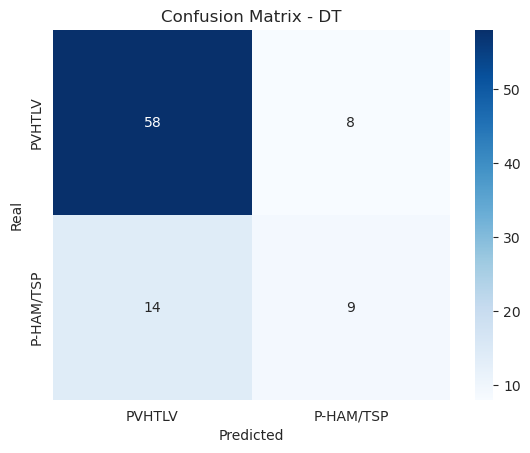

Método de balanceamento desconhecido: SMOTENC
Predicted labels distribution for GB: [65 24]


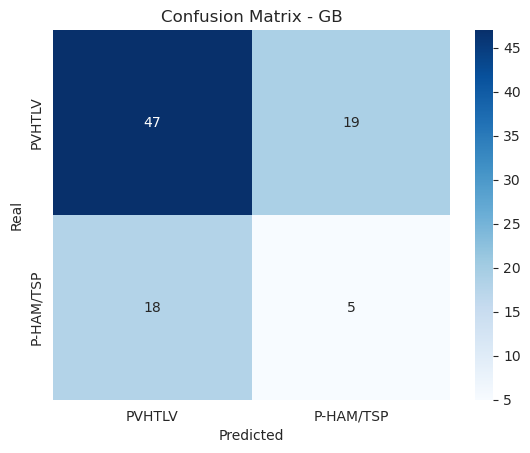

Método de balanceamento desconhecido: SMOTENC
Predicted labels distribution for LR: [53 36]


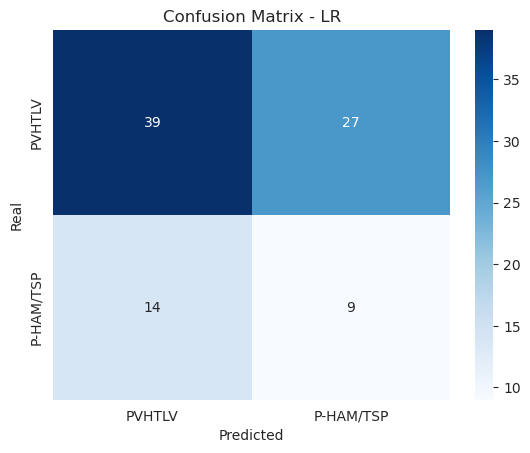

Método de balanceamento desconhecido: SMOTENC


/home/bioinfo-icb/anaconda3/envs/ML_HTLV/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (783) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/bioinfo-icb/anaconda3/envs/ML_HTLV/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (783) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/bioinfo-icb/anaconda3/envs/ML_HTLV/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (783) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/bioinfo-icb/anaconda3/envs/ML_HTLV/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (783) reached and the optimization has

Predicted labels distribution for MLP: [57 32]


/home/bioinfo-icb/anaconda3/envs/ML_HTLV/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (783) reached and the optimization hasn't converged yet.
  warnings.warn(


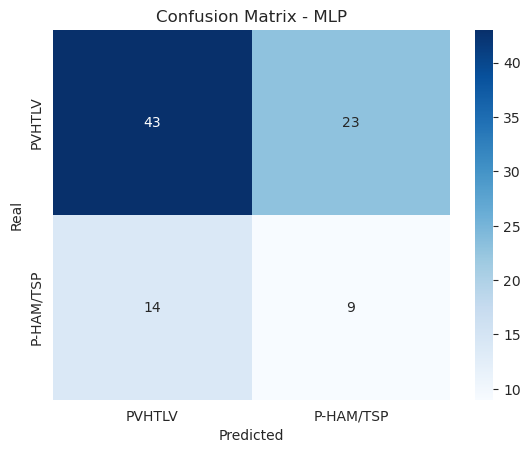

Método de balanceamento desconhecido: SMOTENC
Predicted labels distribution for NB: [57 32]


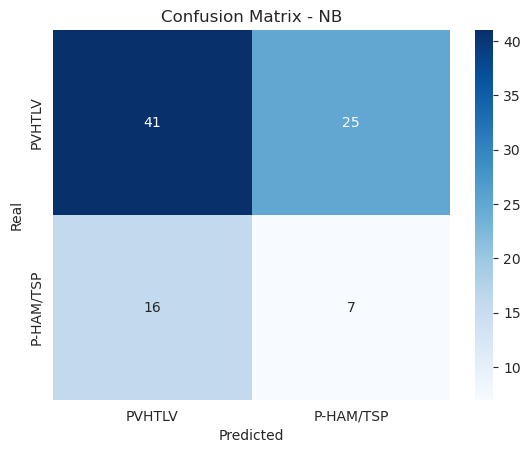

Método de balanceamento desconhecido: SMOTENC
Predicted labels distribution for RF: [64 25]


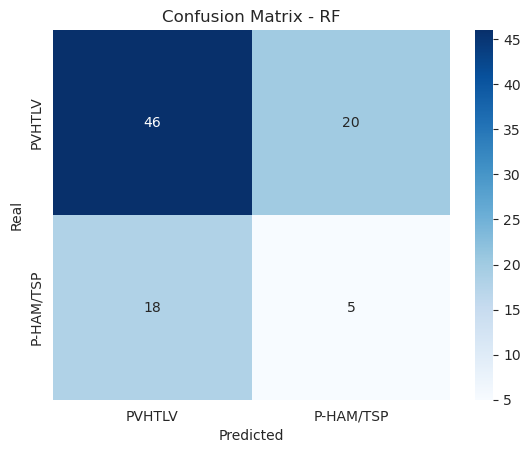

Método de balanceamento desconhecido: SMOTENC
Predicted labels distribution for SVM: [87  2]


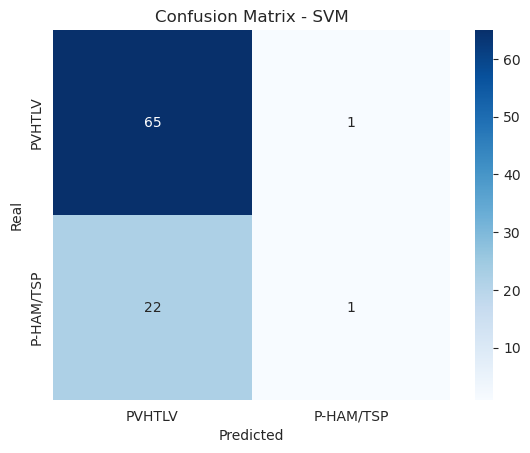

Método de balanceamento desconhecido: SMOTENC
Predicted labels distribution for KNN: [53 36]


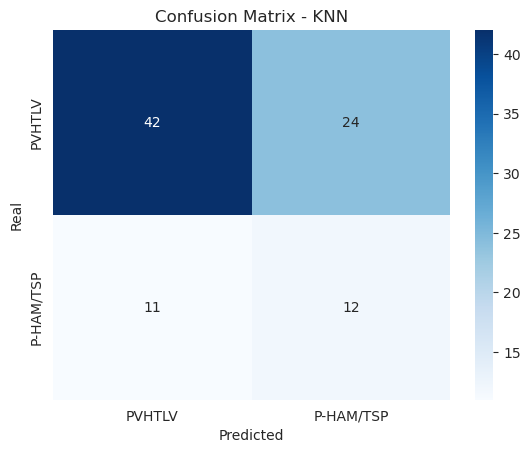

Método de balanceamento desconhecido: SMOTENC
Predicted labels distribution for AB: [62 27]


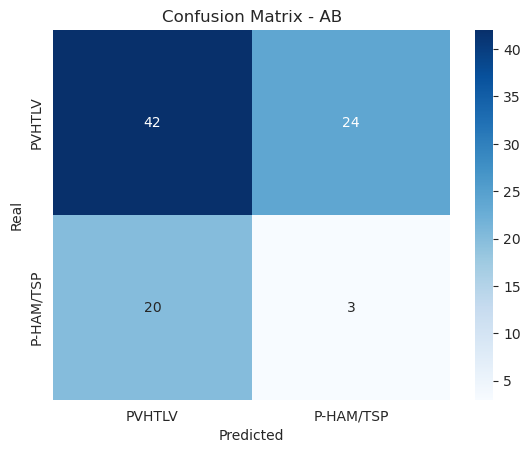

Método de balanceamento desconhecido: SMOTENC


/home/bioinfo-icb/anaconda3/envs/ML_HTLV/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/bioinfo-icb/anaconda3/envs/ML_HTLV/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/bioinfo-icb/anaconda3/envs/ML_HTLV/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/bioinfo-icb/anaconda3/envs/ML_HTLV/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/bioinfo-icb/anaconda3/envs/ML_HTLV/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home

Predicted labels distribution for LSVM: [52 37]


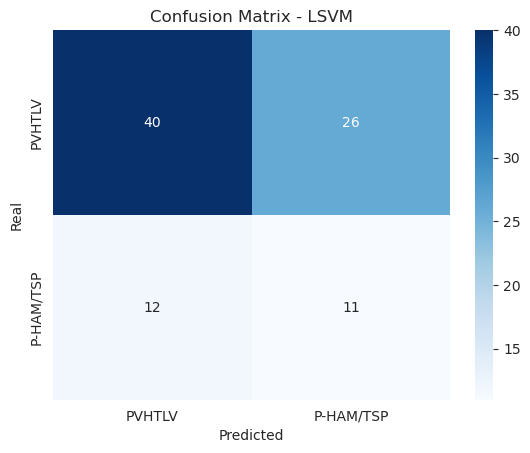

In [11]:
def get_balancing_method():
    global balancing_method_selected
    if balancing_method_selected == 'Random Over Sampler':
        return RandomOverSampler(random_state=42)
    elif balancing_method_selected == 'ADASYN':
        return ADASYN(random_state=42)
    elif balancing_method_selected == 'Random Under Sampler':
        return RandomUnderSampler(random_state=42)
    elif balancing_method_selected == 'Tomek Links':
        return TomekLinks()
    else:
        print(f"Método de balanceamento desconhecido: {balancing_method_selected}")
        return None

def plot_confusion_matrix(model_name):
    # Select the model
    model = classifiers[model_name]

    # Get the balancing method
    balancing_method = get_balancing_method()

    # Define the pipeline using the balancing method and the classifier
    pipeline = Pipeline([
        ('balancing', balancing_method),  # Balanceamento usando método selecionado
        ('classifier', model)  # Classificador
    ])
    
    # Making predictions using cross_val_predict with the pipeline
    y_preds = cross_val_predict(pipeline, X, y, cv=loo)

    # Calculate the confusion matrix
    cm = confusion_matrix(y, y_preds) 
    
    # Print the predicted labels distribution for debugging
    print(f"Predicted labels distribution for {model_name}: {np.bincount(y_preds)}")
    
    # Define custom labels
    labels = ['PVHTLV', 'P-HAM/TSP']

    # Plot the heat map
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Real')
    plt.title(f'Confusion Matrix - {model_name}')
    
    # Save the picture
    plt.savefig(f'..\results\{model_name}_confusion_matrix.jpeg')
    plt.show()

# Iterating over each model in classifiers
for model_name in classifiers:
    plot_confusion_matrix(model_name)


Confunsion matrix with the balancing method in the plot

Predicted labels distribution for DT: [148]


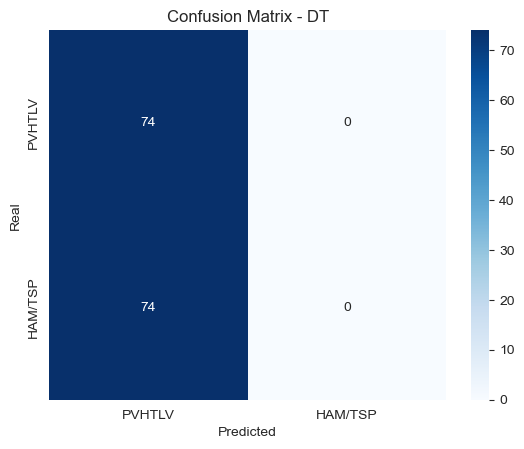

Predicted labels distribution for GB: [73 75]


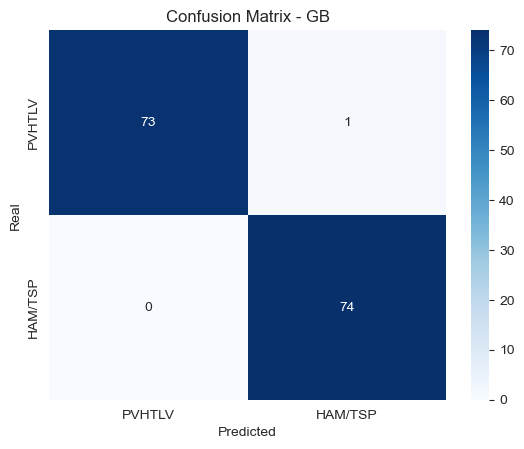

Predicted labels distribution for LR: [95 53]


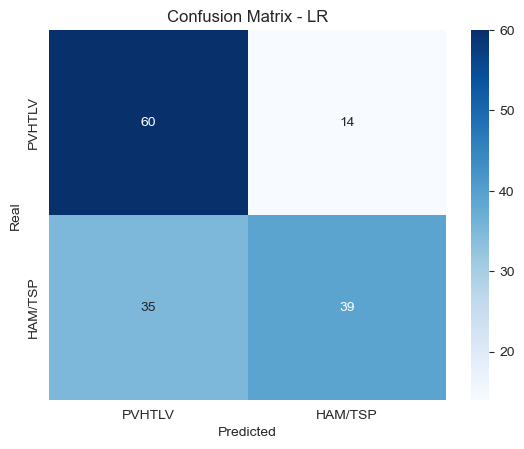

Predicted labels distribution for MLP: [73 75]


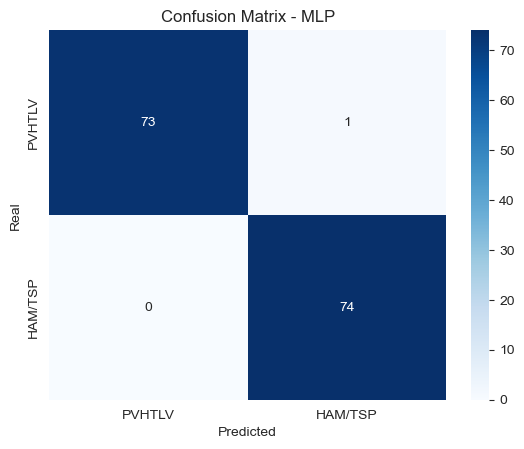

Predicted labels distribution for NB: [94 54]


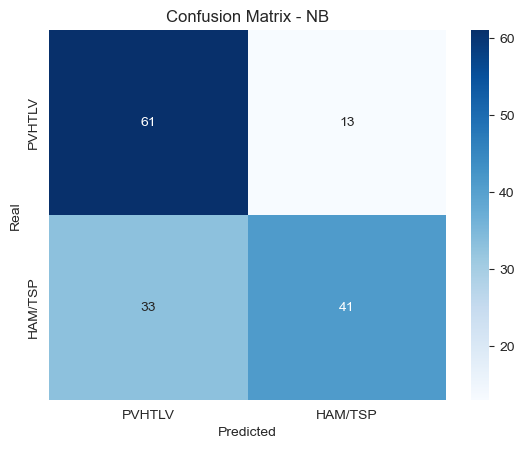

Predicted labels distribution for RF: [68 80]


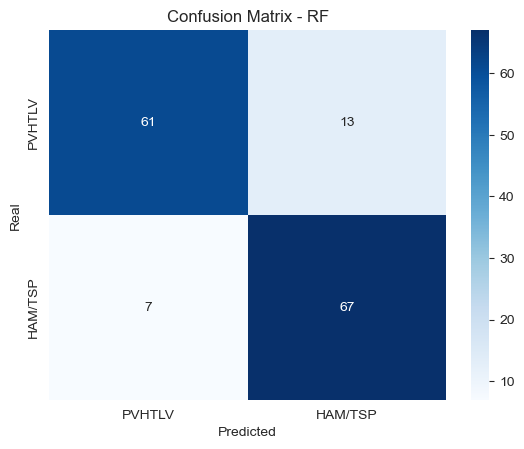

Predicted labels distribution for SVM: [73 75]


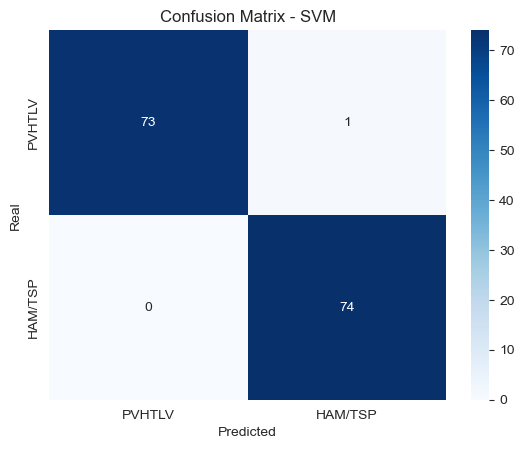

Predicted labels distribution for KNN: [73 75]


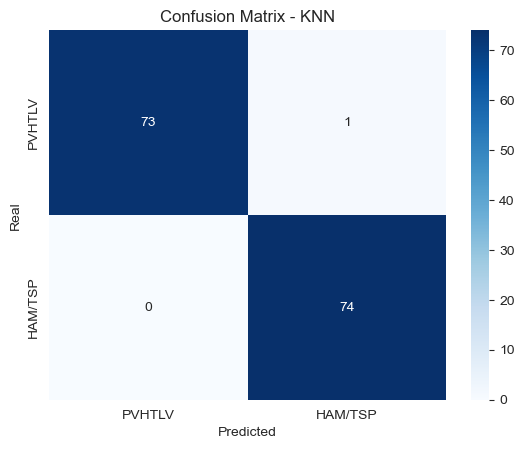

c:\Users\mathe\anaconda3\envs\ML-2024python3_11_\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Predicted labels distribution for AB: [73 75]


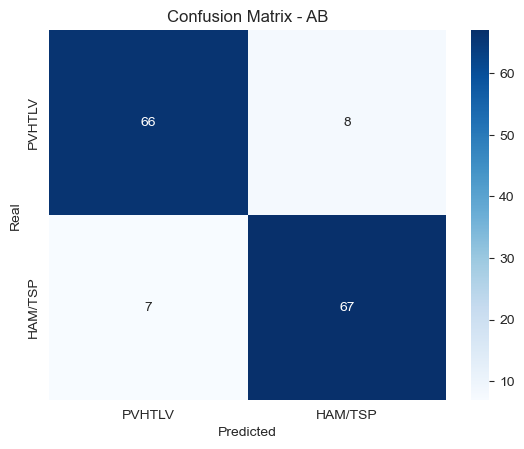

c:\Users\mathe\anaconda3\envs\ML-2024python3_11_\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Predicted labels distribution for LSVM: [92 56]


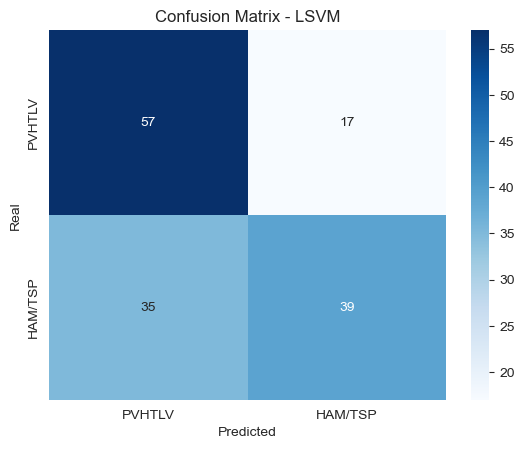

In [43]:
def plot_confusion_matrix(model_name):
    # Select the model
    model = classifiers[model_name]

    # Get the balancing method
    balancing_method = get_balancing_method()

    # Define the pipeline using the balancing method and the classifier
    pipeline = Pipeline([
        ('balancing', balancing_method),  # Balanceamento usando método selecionado
        ('classifier', model)  # Classificador
    ])
    
    # Fit the pipeline to the data
    pipeline.fit(X, y)
    
    # Resample the data using the balancing method
    X_res, y_res = balancing_method.fit_resample(X, y)
    
    # Make predictions on the resampled data
    y_preds = pipeline.predict(X_res)
    
    # Calculate the confusion matrix
    cm = confusion_matrix(y_res, y_preds) 
    
    # Print the predicted labels distribution for debugging
    print(f"Predicted labels distribution for {model_name}: {np.bincount(y_preds)}")
    
    # Define custom labels
    labels = ['PVHTLV', 'HAM/TSP']

    # Plot the heat map
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Real')
    plt.title(f'Confusion Matrix - {model_name}')
    
    # Save the picture
    #plt.savefig(f'../results/{model_name}_confusion_matrix.jpeg')
    plt.show()
# Iterating over each model in classifiers
for model_name in classifiers:
    plot_confusion_matrix(model_name)